# Lab 5 - Support Vector Machines

In this lab we will solve a classification problem using a Support Vector Machine (SVM). As you have seen in class one intuition for introducing this popular model comes from Logistic Regression (LR). In fact the loss of the SVM can be seen also as an approximation of the (regularized) LR loss.

* Logistic Regression Loss (regularized): 

$$J_{LR}(\theta) = \frac{1}{M}\sum_{i=1}^M y^{(i)} \log(h_{\theta}(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_{\theta}(x^{(i)})) + \frac{\lambda}{2M}\sum_{j=1}^N \theta^2_{j} $$

* Support Vector Machine Loss: 

$$J_{SVM}(\theta) = C\sum_{i=1}^M y^{(i)} max(0, 1 - h_{\theta}(x)) + (1 - y^{(i)}) max(0, 1 + h_{\theta}(x)) + \frac{1}{2}\sum_{j=1}^N \theta^2_{j} $$



<img src="https://i.ibb.co/SNKS81J/Screenshot-2020-05-26-at-6-42-35-PM.png" alt="" border="0" width="100%">


where the SVM hypothesis is:

$$h_{\theta}(x) = \theta^T x$$

and the final prediction is:

$$\hat{y}_{\theta}(x) = \mathbb{1}\{h_{\theta}(x) \geq 0\} = \mathbb{1}\{\theta^T x \geq 0\}$$

(Remember that $x$ in this notation has the 1 appended on the last dimension)

In [ ]:
##################################################
# Imports
##################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.datasets import make_blobs

# Settings
plt.style.use('seaborn')

In [ ]:
##################################################
# Parameters
##################################################

SEED = 12345
TRAIN_RATIO = 0.6

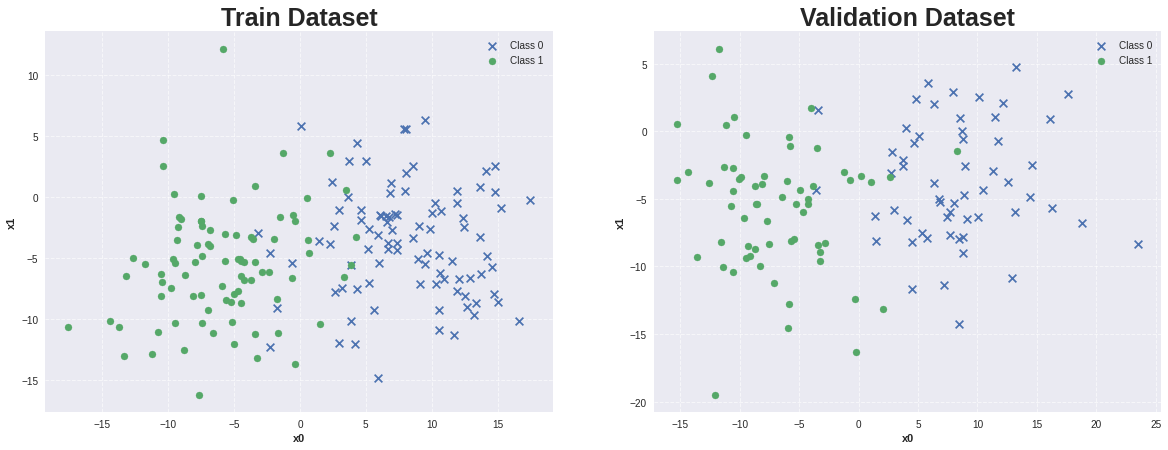

In [ ]:
##################################################
# Dataset
##################################################

x_raw, y = make_blobs(n_samples=300, centers=2, random_state=SEED, cluster_std=4.60)

# Split into train and validation set
n_tr = int(np.ceil(len(x_raw) * TRAIN_RATIO))
idx_samples = np.arange(len(x_raw))
np.random.seed(SEED)
np.random.shuffle(idx_samples)
x_train_raw, y_train = x_raw[idx_samples[:n_tr]], y[idx_samples[:n_tr]]
x_validation_raw, y_validation = x_raw[idx_samples[n_tr:]], y[idx_samples[n_tr:]]

# Plot the dataset
plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
plt.title('Train Dataset', fontweight='bold', fontsize=25)
plt.scatter([x_i[0] for i, x_i in enumerate(x_train_raw) if y_train[i] == 0], 
            [x_i[1] for i, x_i in enumerate(x_train_raw) if y_train[i] == 0], 
            label='Class 0', s=60, marker='x')
plt.scatter([x_i[0] for i, x_i in enumerate(x_train_raw) if y_train[i] == 1], 
            [x_i[1] for i, x_i in enumerate(x_train_raw) if y_train[i] == 1], 
            label='Class 1')
plt.grid(True, alpha=0.6, zorder=0, ls='--')
plt.xlabel('x0', fontweight='bold')
plt.ylabel('x1', fontweight='bold')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Validation Dataset', fontweight='bold', fontsize=25)
plt.scatter([x_i[0] for i, x_i in enumerate(x_validation_raw) if y_validation[i] == 0], 
            [x_i[1] for i, x_i in enumerate(x_validation_raw) if y_validation[i] == 0], 
            label='Class 0', s=60, marker='x')
plt.scatter([x_i[0] for i, x_i in enumerate(x_validation_raw) if y_validation[i] == 1], 
            [x_i[1] for i, x_i in enumerate(x_validation_raw) if y_validation[i] == 1], 
            label='Class 1')
plt.grid(True, alpha=0.6, zorder=0, ls='--')
plt.xlabel('x0', fontweight='bold')
plt.ylabel('x1', fontweight='bold')
plt.legend()

plt.show()

## Preprocess the dataset

* **Normalization**: in this way our dataset has zero mean and unit scalar deviation (important for the optimization step)

$$x_i \leftarrow \frac{x_i - \mu_x}{\sigma_x} \ \ \forall i$$

* **Append $1$ to $x$**: in this way we include the bias in the parameter vector

$$x_i \leftarrow [x_i, 1]  \ \ \forall i$$

In [ ]:
##################################################
# Pre-process dataset
##################################################

# Normalize the dataset
x_mu, x_std = x_train_raw.mean(axis=0), x_train_raw.std(axis=0)
x_train = (x_train_raw - x_mu) / x_std
x_validation = (x_validation_raw - x_mu) / x_std

# Append ones column
x_train = np.concatenate([x_train, np.ones([len(x_train), 1], dtype=np.float32)], axis=-1)
x_validation = np.concatenate([x_validation, np.ones([len(x_validation), 1], dtype=np.float32)], axis=-1)

# Reshape target
y_train = y_train.reshape(-1, 1)
y_validation = y_validation.reshape(-1, 1)

In [ ]:
# Dataset information
print("x_train shape: ", x_train.shape)
print("x_validation shape: ", x_validation.shape)
print("Fisrt ten y_target: ", y_train[:10].reshape(-1))

x_train shape:  (180, 3)
x_validation shape:  (120, 3)
Fisrt ten y_target:  [1 0 0 0 1 0 1 0 0 1]


# SVM Model

Here there is a class that implement a Support Vector Machine. In this lab we will train this model using Stochastic Gradiend Descent. The gradient is already implemented but here you can find how to compute it.

For the $i^{th}$ data point we have (the $i^{th}$ index is omitted for simplifing the notation):


$$\frac{\partial J_{SVM} (\theta)}{\partial \theta} = \frac{\partial J_{SVM}}{\partial h_{\theta} (x)} \frac{\partial h_{\theta} (x)}{\partial \theta} + θ = C[(1 - y)\textbf{1}\{ h \geq -1 \} - y\textbf{1}\{h \leq 1\}] + \theta $$

In [ ]:
##################################################
# SVM Class
##################################################

class SVM(object):
    def __init__(self, theta_dim=3, seed=1234):
        np.random.seed(seed)
        self.theta = np.random.normal(loc=0.01, size=[theta_dim, 1]) # shape [theta_dim, 1]
        self.theta[-1] = 0 # Zero initialization for the bias

    def forward(self, x):
        '''
        input x: ndarray of shape [N, theta_dim]
        output h: ndarray of shape [N, 1]
        '''
        h = None
        ##############################
        # INSERT YOUR CODE HERE
        ##############################
        h = np.dot(x, self.theta)
        ##############################
        # END OF YOUR CODE
        ##############################
        return h

    def loss(self, h, y, C):
        '''
        input h: ndarray of shape [N, 1]
        input y: ndarray of shape [N, 1]
        output j: scalar
        '''
        j = None
        ##############################
        # INSERT YOUR CODE HERE
        ##############################
        cost1 = y * np.maximum(1-h,0)
        cost2= (1-y) * np.maximum(1+h,0)
        B = np.sum(self.theta**2) / 2
        A = np.sum(cost1 + cost2)
        j = C*A + B

        ##############################
        # END OF YOUR CODE
        ##############################
        return j

    def fit(self, x, y, x_val, y_val, C=1, lr=1e-3, iterations=100, print_every=10, batch_size=32, seed=1234):
        '''
        input x: ndarray of shape [N, theta_dim]
        input y: ndarray of shape [N, 1]
        '''
        idx_samples = np.arange(len(x))
        loss = {'train': [], 'validation': []}
        for it in range(iterations):

            # Batches
            np.random.seed(seed)
            np.random.shuffle(idx_samples)
            num_batches = int(np.ceil(len(x) / batch_size))
            loss_epoch = []
            for idx_b in range(num_batches):
                idx_batch = idx_samples[idx_b * batch_size : (idx_b + 1) * batch_size]
                x_batch, y_batch = x[idx_batch], y[idx_batch]

                # Forward and loss
                h = self.forward(x_batch) # shape [batch_size,]
                loss_epoch += [self.loss(h, y_batch, C=C)]
            
                # Compute the gradient
                grad = 1.0 * (y_batch == 0) * (h >= -1) - 1.0 * (y_batch == 1) * (h <= 1)
                grad = C * (np.tile(grad, (1, x_batch.shape[-1])) * x_batch).sum(axis=0, keepdims=True).T
                grad = grad + self.theta

                # Update the gradient
                self.theta = self.theta - lr * grad

            loss['train'] += [np.mean(loss_epoch)]

            # Validation step
            h_val = self.forward(x_val)
            loss['validation'] += [self.loss(h_val, y_val, C=C)]

            # Print log
            if print_every is not None:
                if (it % print_every == 0) or (it == iterations - 1):
                    print(f'Iter: {it}\n\ttrain loss {loss["train"][-1]:.3f}, validation loss {loss["validation"][-1]:.3f}')
        return loss

    def predict(self, x):
        '''
        input x: ndarray of shape [N, theta_dim]
        output y_: ndarray of shape [N, 1]
        '''
        y_ = None
        ##############################
        # INSERT YOUR CODE HERE
        ##############################
        h = self.forward(x)
        y_ = 1 * (h >= 0)
     
        ##############################
        # END OF YOUR CODE
        ##############################
        return y_

    def evaluate(self, x, y, metric_func):
        '''
        input x: ndarray of shape [N, theta_dim]
        input y: ndarray of shape [N, 1]
        input metric_func: function for evaluation
        '''
        y_ = self.predict(x)
        return metric_func(y_, y)

# Train the SVM

In [ ]:
# Create and fit a SVM
svm = SVM()
loss = svm.fit(x_train, y_train, x_validation, y_validation, C=3, lr=1e-4, iterations=2000, print_every=100)

Iter: 0
	train loss 112.806, validation loss 459.586
Iter: 100
	train loss 22.225, validation loss 70.554
Iter: 200
	train loss 19.515, validation loss 61.759
Iter: 300
	train loss 18.836, validation loss 58.837
Iter: 400
	train loss 18.692, validation loss 58.119
Iter: 500
	train loss 18.631, validation loss 57.558
Iter: 600
	train loss 18.587, validation loss 57.424
Iter: 700
	train loss 18.572, validation loss 57.425
Iter: 800
	train loss 18.573, validation loss 57.390
Iter: 900
	train loss 18.572, validation loss 57.384
Iter: 1000
	train loss 18.579, validation loss 57.367
Iter: 1100
	train loss 18.574, validation loss 57.351
Iter: 1200
	train loss 18.571, validation loss 57.322
Iter: 1300
	train loss 18.575, validation loss 57.322
Iter: 1400
	train loss 18.572, validation loss 57.309
Iter: 1500
	train loss 18.571, validation loss 57.296
Iter: 1600
	train loss 18.570, validation loss 57.292
Iter: 1700
	train loss 18.570, validation loss 57.273
Iter: 1800
	train loss 18.574, validat

In [ ]:
# Accuracy
from sklearn.metrics import accuracy_score
def accuracy(y_, y):
    return (y_ == y).mean()

# Evaluate
acc_train = svm.evaluate(x_train, y_train, accuracy)
acc_validation = svm.evaluate(x_validation, y_validation, accuracy)
print(f'Train accuracy {100 * acc_train:.2f}%, validation accuracy {100 * acc_validation:.2f}%')

Train accuracy 92.22%, validation accuracy 95.00%


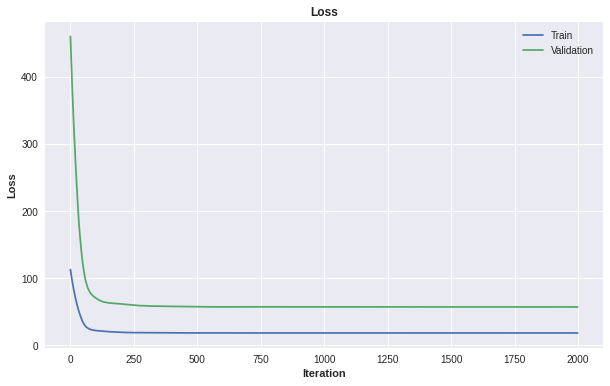

In [ ]:
# Plot loss
plt.figure(figsize=(10, 6))
plt.title('Loss', fontweight='bold')
for key, l in loss.items():
    plt.plot(l, label=key.capitalize())
plt.legend()
plt.xlabel('Iteration', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.show()

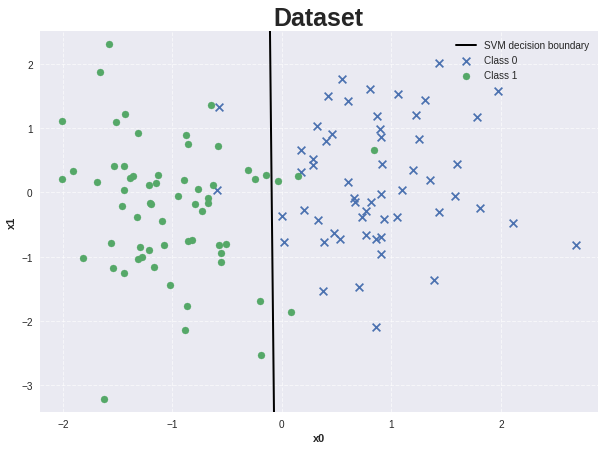

In [ ]:
# Plot the decision boundary
a, b, c = svm.theta.copy()
x_in = np.linspace(-2, 2, 100)

plt.figure(figsize=(10, 7))
plt.plot(x_in, - a / b * x_in - c / b, c='k', label='SVM decision boundary', lw=2)
plt.title('Dataset', fontweight='bold', fontsize=25)
plt.scatter([x_i[0] for i, x_i in enumerate(x_validation) if y_validation[i] == 0], 
            [x_i[1] for i, x_i in enumerate(x_validation) if y_validation[i] == 0], 
            label='Class 0', s=60, marker='x')
plt.scatter([x_i[0] for i, x_i in enumerate(x_validation) if y_validation[i] == 1], 
            [x_i[1] for i, x_i in enumerate(x_validation) if y_validation[i] == 1], 
            label='Class 1')
plt.grid(True, alpha=0.6, zorder=0, ls='--')
plt.xlabel('x0', fontweight='bold')
plt.ylabel('x1', fontweight='bold')
plt.xlim(x_validation[:, 0].min() - 0.2, x_validation[:, 0].max() + 0.2)
plt.ylim(x_validation[:, 1].min() - 0.2, x_validation[:, 1].max() + 0.2)
plt.legend()
plt.show()

# Changing the $C$ parameter

Here you can see the impact of the parameter $C$ respecto to the decision boundary fo the SVM. 

In [ ]:
# Search for C
svms, losses = {}, {}
for c in [0.05, 0.1, 0.5, 0.8, 1, 1.5, 5]:
    print(f'Fitting svm with C = {c}')
    svms[c] = SVM()
    losses[c] = svms[c].fit(x_train, y_train, x_validation, y_validation, C=c, lr=1e-4, iterations=2000, print_every=None)

Fitting svm with C = 0.05
Fitting svm with C = 0.1
Fitting svm with C = 0.5
Fitting svm with C = 0.8
Fitting svm with C = 1
Fitting svm with C = 1.5
Fitting svm with C = 5


In [ ]:
# Evaluate
accs = {}
for c, svm in svms.items(): 
    acc = svm.evaluate(x_validation, y_validation, accuracy)
    accs[c] = acc
    print(f'C = {c}, validation accuracy {100 * acc:.2f}%')

C = 0.05, validation accuracy 90.00%
C = 0.1, validation accuracy 94.17%
C = 0.5, validation accuracy 95.00%
C = 0.8, validation accuracy 95.00%
C = 1, validation accuracy 95.00%
C = 1.5, validation accuracy 95.00%
C = 5, validation accuracy 95.00%


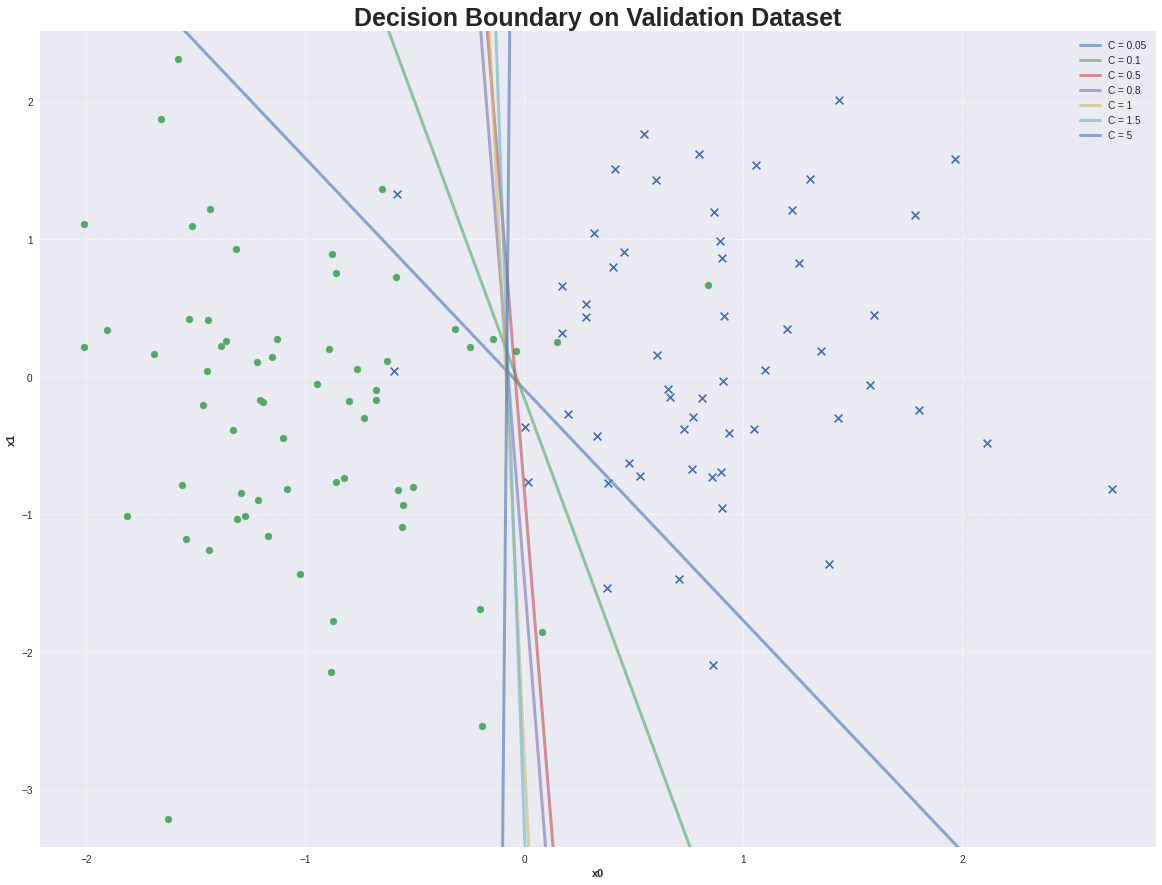

In [ ]:
# Plot the decision boundary
x_in = np.linspace(-2, 2, 100)
plt.figure(figsize=(20, 15))
for key, svm in svms.items():
    a, b, c = svm.theta.copy()
    plt.plot(x_in, - a / b * x_in - c / b, label=f'C = {key}', lw=3, alpha=0.6)
plt.title('Decision Boundary on Validation Dataset', fontweight='bold', fontsize=25)
plt.scatter([x_i[0] for i, x_i in enumerate(x_validation) if y_validation[i] == 0], 
            [x_i[1] for i, x_i in enumerate(x_validation) if y_validation[i] == 0], s=60, marker='x')
plt.scatter([x_i[0] for i, x_i in enumerate(x_validation) if y_validation[i] == 1], 
            [x_i[1] for i, x_i in enumerate(x_validation) if y_validation[i] == 1])
plt.grid(True, alpha=0.6, zorder=0, ls='--')
plt.xlabel('x0', fontweight='bold')
plt.ylabel('x1', fontweight='bold')
plt.xlim(x_validation[:, 0].min() - 0.2, x_validation[:, 0].max() + 0.2)
plt.ylim(x_validation[:, 1].min() - 0.2, x_validation[:, 1].max() + 0.2)
plt.legend()
plt.show()

## SVM with Kernels
- A kernel is a function $\varphi: \mathbb{R}^n \rightarrow \mathbb{R}^m$ which maps our vectors in $\mathbb{R}^n$ to some (possibly very high dimensional) space $\mathbb{R}^m$.
- Kernels are sometimes called “generalized dot product”:
  - $x, y \in \mathbb{R}^n$ $\hspace{1cm}$ $K(x, y) = \varphi(x)^T\varphi(y)$ corresponds to a dot product in $\mathbb{R}^n$.
- Kernel Functions are used to adapt linear regression (or classification) models to non-linear data.
- Some examples:
  - $Linear(x, x') = x \cdot x'$
  - $Poly(x, x') = (1+ x\cdot x' )^p$
  - $RBF(x, x') = exp(-\gamma ||x-x'||^2)$

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


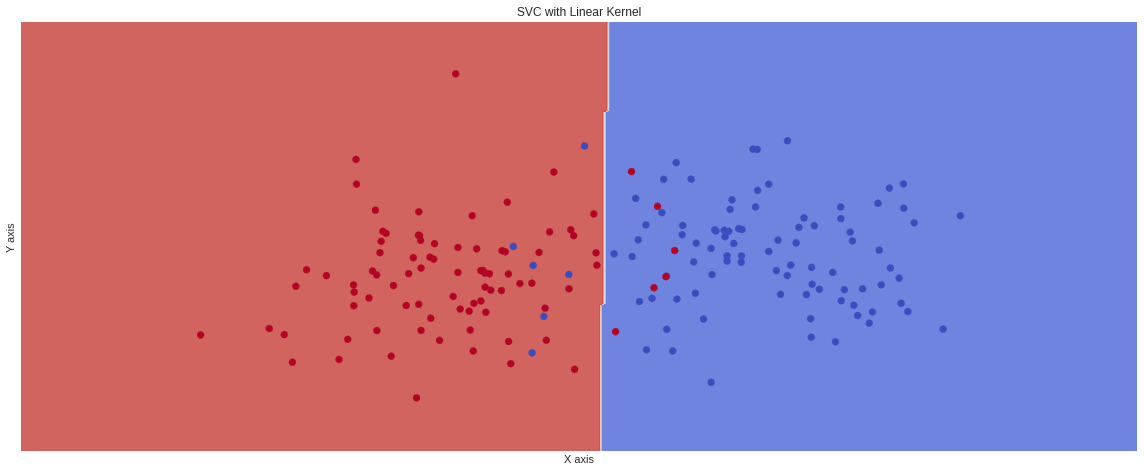

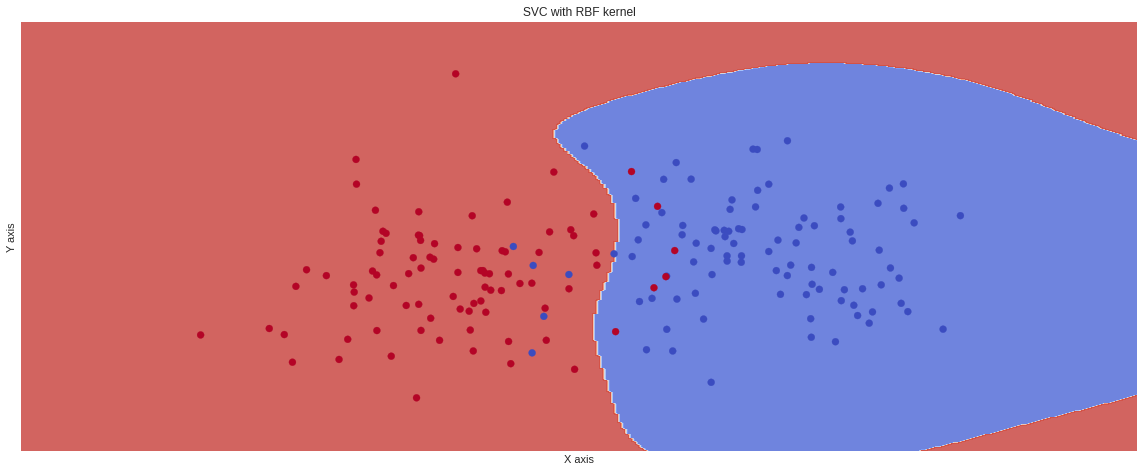

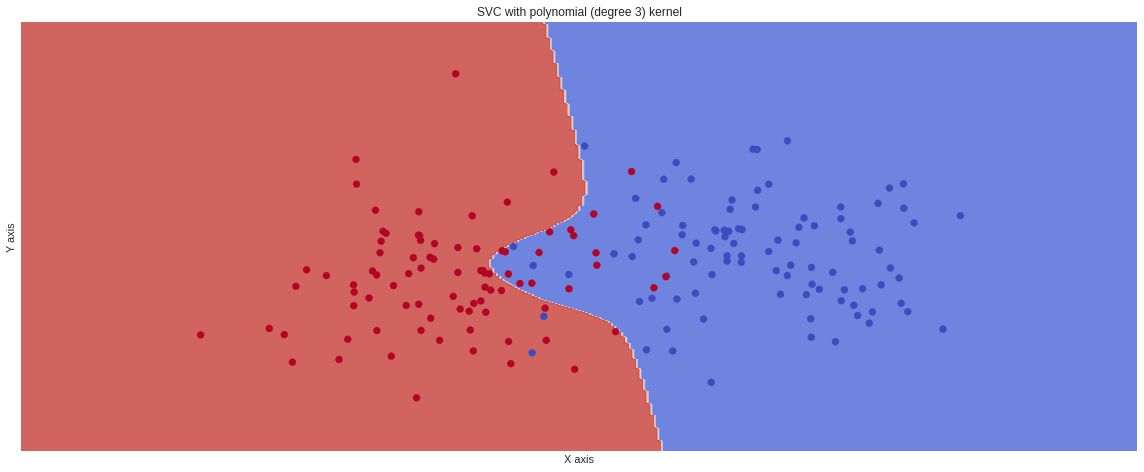

In [ ]:
from sklearn import svm

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(x_train[:,:2], y_train)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.9, C=C).fit(x_train[:,:2], y_train)
poly_svc = svm.SVC(kernel='poly', degree=5, C=C).fit(x_train[:,:2], y_train)
# create a mesh to plot in
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with Linear Kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.figure(figsize=(20, 30))
    plt.subplot(3,1, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    ravel = np.c_[xx.ravel(), yy.ravel()]
    
    Z = clf.predict(ravel)
    
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.coolwarm)
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

## CIFAR-10 classification with SVM
Try to use sklearn built-in SVM to classify images from CIFAR-10.
Documentation: [Scikit SVM Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [ ]:
from sklearn import svm
# Download dataset
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz 
!rm -r sample_data

--2022-04-26 10:30:31--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  63.4MB/s    in 2.6s    

2022-04-26 10:30:35 (63.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
from six.moves import cPickle as pickle
import platform
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        #X = np.dot(X[...,:3], [0.2989, 0.5870, 0.1140])
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. 
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)
    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, _, _ = get_CIFAR10_data()
X_train = X_train[:2000]
y_train = y_train[:2000]
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)


Train data shape:  (2000, 3072)
Train labels shape:  (2000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)


In [ ]:
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.305

In [ ]:
for degree in range(10):
  clf = svm.SVC(kernel='poly', degree=degree, C=1.0)
  clf.fit(X_train, y_train)
  print('Degree: {}, Score:{}'.format(degree, clf.score(X_val, y_val)))

Degree: 0, Score:0.078
Degree: 1, Score:0.364
Degree: 2, Score:0.293
Degree: 3, Score:0.283
Degree: 4, Score:0.174
Degree: 5, Score:0.176
Degree: 6, Score:0.131
Degree: 7, Score:0.133
Degree: 8, Score:0.115
Degree: 9, Score:0.121


In [ ]:
gamma=1/(3072*X_train.var())
for gamma in range(1,11):
  clf = svm.SVC(kernel='rbf', gamma=1*10**(-gamma), C=1.0)
  clf.fit(X_train, y_train)
  print('Gamma: {}, Score:{}'.format(1*10**(-gamma), clf.score(X_val, y_val)))

Gamma: 0.1, Score:0.078
Gamma: 0.01, Score:0.078
Gamma: 0.001, Score:0.078
Gamma: 0.0001, Score:0.078
Gamma: 1e-05, Score:0.078
Gamma: 1e-06, Score:0.215
Gamma: 1e-07, Score:0.399
Gamma: 1e-08, Score:0.355
Gamma: 1e-09, Score:0.214
Gamma: 1e-10, Score:0.078


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
X_train = X_train[:3000]
y_train = y_train[:3000]
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
clf = svm.SVC(kernel='rbf', gamma=1*10**(-7), C=1.0)
clf.fit(X_train, y_train)

Train data shape:  (3000, 3072)
Train labels shape:  (3000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)


SVC(gamma=1e-07)

In [ ]:
clf.score(X_val, y_val)

0.438